# **M1:Feedforward Classifier For MNIST**

### Here we have build a FlexibleMLP that accepts configuration flags(dropout,batchnorm,initialization) for the experiments

### 1.Setup & Data Preprocessing

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np

# ---- Reproducibility: Seed everything
# to get the exact same results everytime for every code run like for data shuffling and weight init
def set_seed(seed = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data & Preprocessing ---
# Normalizing to (0.1307,0.3081) are MNIST specific global mean/std
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307),(0.3081))
])

# --- Load Full train Data
full_dataset = datasets.MNIST('./data',train = True,download = True,transform = transform)
test_dataset = datasets.MNIST('./data',train = False,download = True,transform = transform)

# --- Split to Train(50k) and Val(10k) from full_dataset ---
train_dataset, val_dataset = random_split(full_dataset, [50000,10000])

# --- Dataloaders ---
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = BATCH_SIZE,shuffle = True)

### 2.The Flexible Model (Baseline + Experiment Flags)

In [17]:
class FlexibleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=64, output_dim=10, 
                 dropout_prob=0.0, use_batchnorm=False, init_type='default'):
        super().__init__()
        self.use_batchnorm = use_batchnorm
        
        # Layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        if use_batchnorm:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        # Layer 2
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        if use_batchnorm:
            self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_prob)
        
        # Output Layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # Initialization Logic
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'kaiming':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.xavier_uniform_(self.fc3.weight) # Output usually Linear/Xavier

    def forward(self, x):
        x = x.view(-1, 784) # Flatten
        
        # Block 1
        x = self.fc1(x)
        if self.use_batchnorm: x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.fc2(x)
        if self.use_batchnorm: x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        
        # Output
        x = self.fc3(x)
        return x

In [18]:
def run_experiment(model, optimizer, epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # --- TRAIN ---
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # --- VALIDATION ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                _, pred = torch.max(out, 1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        
        val_acc = 100 * correct / total
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
    return history

In [21]:
# --- EXAMPLE EXPERIMENT 1: BASELINE ---
print("--- Running Baseline ---")
model_base = FlexibleMLP(use_batchnorm=False, dropout_prob=0.0)
optimizer = optim.Adam(model_base.parameters(), lr=1e-3)
hist_base = run_experiment(model_base, optimizer, epochs=5)

--- Running Baseline ---


KeyboardInterrupt: 

In [22]:
# --- EXAMPLE EXPERIMENT 2: WITH BATCHNORM + DROPOUT ---
print("\n--- Running BN + Dropout ---")
model_exp = FlexibleMLP(use_batchnorm=True, dropout_prob=0.5, init_type='kaiming')
optimizer = optim.Adam(model_exp.parameters(), lr=1e-3)
hist_exp = run_experiment(model_exp, optimizer, epochs=10)


--- Running BN + Dropout ---
Epoch 1 | Loss: 0.9372 | Val Acc: 91.42%
Epoch 2 | Loss: 0.5508 | Val Acc: 92.18%
Epoch 3 | Loss: 0.4702 | Val Acc: 93.58%
Epoch 4 | Loss: 0.4217 | Val Acc: 94.25%
Epoch 5 | Loss: 0.3904 | Val Acc: 94.45%
Epoch 6 | Loss: 0.3688 | Val Acc: 94.89%
Epoch 7 | Loss: 0.3536 | Val Acc: 95.10%
Epoch 8 | Loss: 0.3426 | Val Acc: 95.26%
Epoch 9 | Loss: 0.3329 | Val Acc: 95.18%
Epoch 10 | Loss: 0.3247 | Val Acc: 95.49%


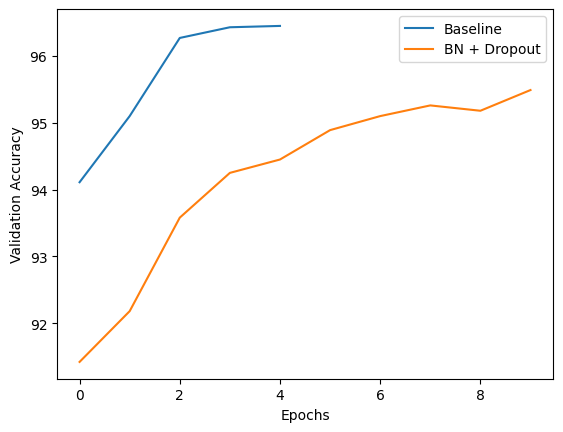

In [23]:
# PLOTTING RESULTS
plt.plot(hist_base['val_acc'], label='Baseline')
plt.plot(hist_exp['val_acc'], label='BN + Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# **M2: Regression on Tabular Data (California Housing)**

### Regression requires different loss (MSELoss), evaluation (RMSE/R2), and crucial preprocessing (StandardScaler).

### 1. Data Loading & Scaling
#### Neural networks struggle if one feature is "0.01" and another is "10000". Scaling is mandatory.

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset

# now loading the data
data = fetch_california_housing()
X,y = data.data, data.target

# split it
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# scaling the data
scaler =  StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert them to tensors
# .float() is imp! because default numpy is double

X_train_t = torch.tensor(X_train, dtype = torch.float32)
y_train_t = torch.tensor(y_train, dtype = torch.float32).view(-1,1) # Shape (N,1)

X_test_t = torch.tensor(X_test, dtype = torch.float32)
y_test_t = torch.tensor(y_test, dtype = torch.float32).view(-1,1)

# Dataloaders
train_ds = TensorDataset(X_train_t,y_train_t)
train_loader_reg = DataLoader(train_ds,batch_size = 32, shuffle =True)

### 2.Regression Model

### Wide Path: Connects inputs directly to output (good for linear memorization).

### Deep Path: Goes through hidden layers (good for non-linear generalization).

### Wide & Deep : Combines the Deep layers + Input layer to combine the linear and non-linear relations for better results

In [9]:
class RegressorNet(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=128, wide_and_deep=False):
        super().__init__()
        self.wide_and_deep = wide_and_deep
        
        # Deep Path
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Output Head
        # If Wide & Deep, we concat the deep output + original input
        final_dim = hidden_dim + input_dim if wide_and_deep else hidden_dim
        self.output = nn.Linear(final_dim, 1) 

    def forward(self, x):
        # Deep Path
        h = torch.relu(self.hidden1(x))
        h = torch.relu(self.hidden2(h))
        
        if self.wide_and_deep:
            # Concatenate the hidden representation with original input
            combined = torch.cat([h, x], dim=1) 
            y = self.output(combined)
        else:
            y = self.output(h)
            
        return y

In [10]:
def train_regression(model, epochs=20):
    model = model.to(device)
    # Regression Loss
    criterion = nn.MSELoss() 
    # Weight Decay experiment example (L2 Regularization)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader_reg:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader_reg)
        train_losses.append(avg_loss)
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1} | MSE Loss: {avg_loss:.4f}")
            
    return train_losses

In [13]:
# Run Training
print("--- Training Regression Model ---")
reg_model = RegressorNet(wide_and_deep=False) # Toggle True for M3
loss_history = train_regression(reg_model,epochs = 50)

--- Training Regression Model ---


Epoch 5 | MSE Loss: 0.3319
Epoch 10 | MSE Loss: 0.2924
Epoch 15 | MSE Loss: 0.2797
Epoch 20 | MSE Loss: 0.2655
Epoch 25 | MSE Loss: 0.2544
Epoch 30 | MSE Loss: 0.2496
Epoch 35 | MSE Loss: 0.2428
Epoch 40 | MSE Loss: 0.2397
Epoch 45 | MSE Loss: 0.2351
Epoch 50 | MSE Loss: 0.2306



Test RMSE: 0.5194


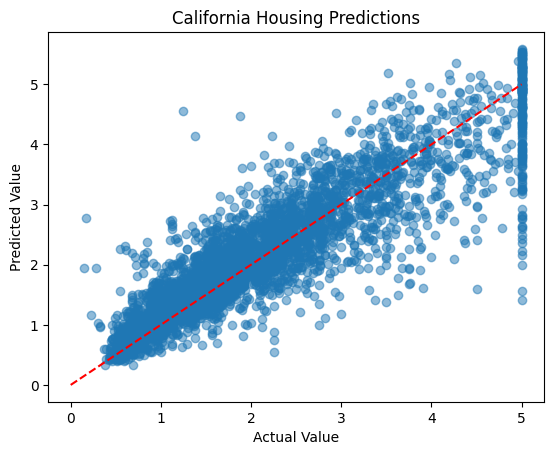

In [14]:
# --- 4. EVALUATION ---
reg_model.eval()
with torch.no_grad():
    X_test_t = X_test_t.to(device)
    preds = reg_model(X_test_t).cpu()
    
    # Calculate RMSE
    mse = nn.MSELoss()(preds, y_test_t)
    rmse = torch.sqrt(mse)
    
    print(f"\nTest RMSE: {rmse.item():.4f}")
    
    # Plot Actual vs Predicted
    plt.scatter(y_test_t.numpy(), preds.numpy(), alpha=0.5)
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.title("California Housing Predictions")
    plt.plot([0, 5], [0, 5], 'r--') # Perfect prediction line
    plt.show()

### **M1 (MNIST):** You will visually see that BatchNorm allows the loss to drop much faster in the first few epochs. You will see that Dropout keeps training accuracy lower but often improves validation accuracy (prevents overfitting).

### **M2 (Regression):** You will realize that without StandardScaler, the loss might never converge. You will see how "Wide & Deep" connections can sometimes capture patterns that a standard stack of layers misses.